In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import PooledOLS
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from scipy import stats


# 1. Importe la base de datos a una base en Jupyter Notebook con pandas. 

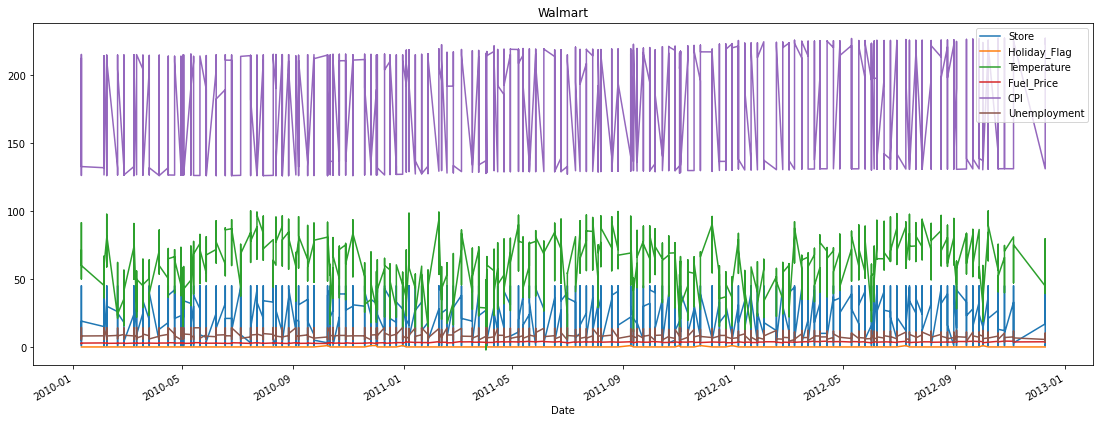

In [2]:
df=pd.read_csv("walma.csv",index_col = 'Date')
df['Weekly_Sales']=round(df['Weekly_Sales']/1000 , 3)
df2= pd.read_csv("walma.csv")
df2['Weekly_Sales']=round(df2['Weekly_Sales']/1000 , 3)
df.index= pd.to_datetime(df.index)

df[['Store',   'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].plot(title = "Walmart", figsize=(19,7))


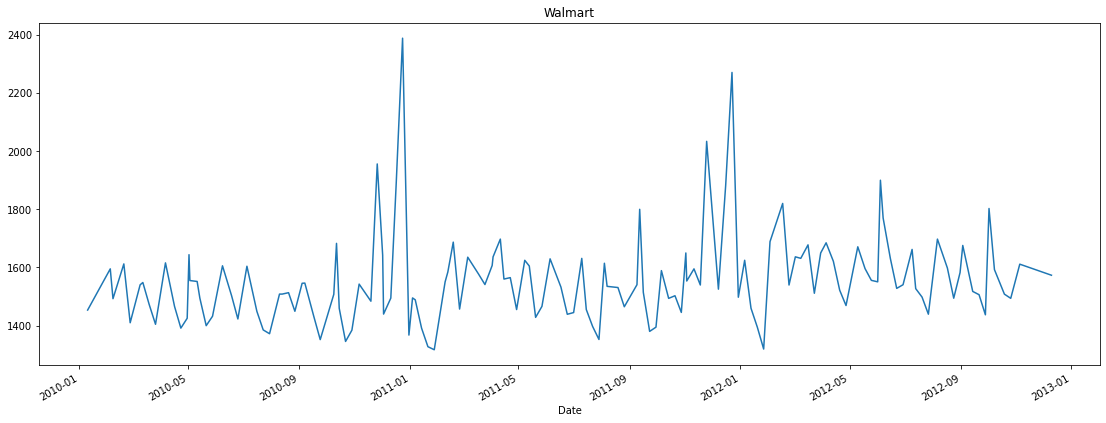

In [3]:
df[df['Store']==1]['Weekly_Sales'].plot(title = "Walmart", figsize=(19,7))

# 2. Obtenga los descriptivos resumen de la base de datos e identifique a las variables numéricas y categóricas. ¿Hay algo que le llame la atención? 

Segun los datos obtenidos podemos identificar que la variable Store hace refencia a una tienda. Existen 45 tiendas y la bases de datos que vamos a estudiar contiene 143 registros por cada tienda que van desde el año 2010 hasta el año 2013. En el grafico obtenido en el apartado 2 podemos apraciar la serie de tiempo de las ganacias de la tienda 1.


La variable Holiday_Flag oma valores de 0,1 y el precio del combustible mantiene una varianza pequeña. 

In [4]:

print(df.columns)
print("\n Datos descriptivos \n")
print(df.describe())
print("\n Datos tipos \n")

print(df.dtypes)




Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

 Datos descriptivos 

             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000   6435.000000   6435.000000  6435.000000  6435.000000   
mean     23.000000   1046.964876      0.069930    60.663782     3.358607   
std      12.988182    564.366622      0.255049    18.444933     0.459020   
min       1.000000    209.986000      0.000000    -2.060000     2.472000   
25%      12.000000    553.350000      0.000000    47.460000     2.933000   
50%      23.000000    960.746000      0.000000    62.670000     3.445000   
75%      34.000000   1420.158500      0.000000    74.940000     3.735000   
max      45.000000   3818.686000      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000    

In [5]:
df['Store'].value_counts()

1     143
24    143
26    143
27    143
28    143
29    143
30    143
31    143
32    143
33    143
34    143
35    143
36    143
37    143
38    143
39    143
40    143
41    143
42    143
43    143
44    143
25    143
23    143
2     143
22    143
3     143
4     143
5     143
6     143
7     143
8     143
9     143
10    143
11    143
12    143
13    143
14    143
15    143
16    143
17    143
18    143
19    143
20    143
21    143
45    143
Name: Store, dtype: int64

In [6]:
df[df.columns[1]].dtypes is np.dtype(object)
cat_field=[i for i in df.columns if df[i].dtypes is np.dtype(object) ] 
quan_field=[i for i in df.columns if df[i].dtypes is not np.dtype(object) ] 
print("lista de variables categoricas " + str(cat_field) )
print("lista de variables cuantitativas  "+ str(quan_field))

lista de variables categoricas []
lista de variables cuantitativas  ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


# 3. Evalúe si la base contiene datos perdidos.


A primera vista no existen valores perdidos

In [7]:
print(df.isnull().sum())

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [8]:
df.isna().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

# 4. Evalúe si alguna de las variables contiene datos atípicos (outliers) 
De ser el caso, detalle cuáles y qué método estadístico aplicarán para corregir. 

Segun los box plot si existen valores atipicos en  'Weekly_Sales' y 'Unemployment' . Sin envargo al estudiar la serie de tiempo utilizando el maximo y el minimo podemos ver la que las graficas muestran una mayor venta a finales del año. Por mencionada razon mantenre la base de datos sin eliminar ningunregistro.

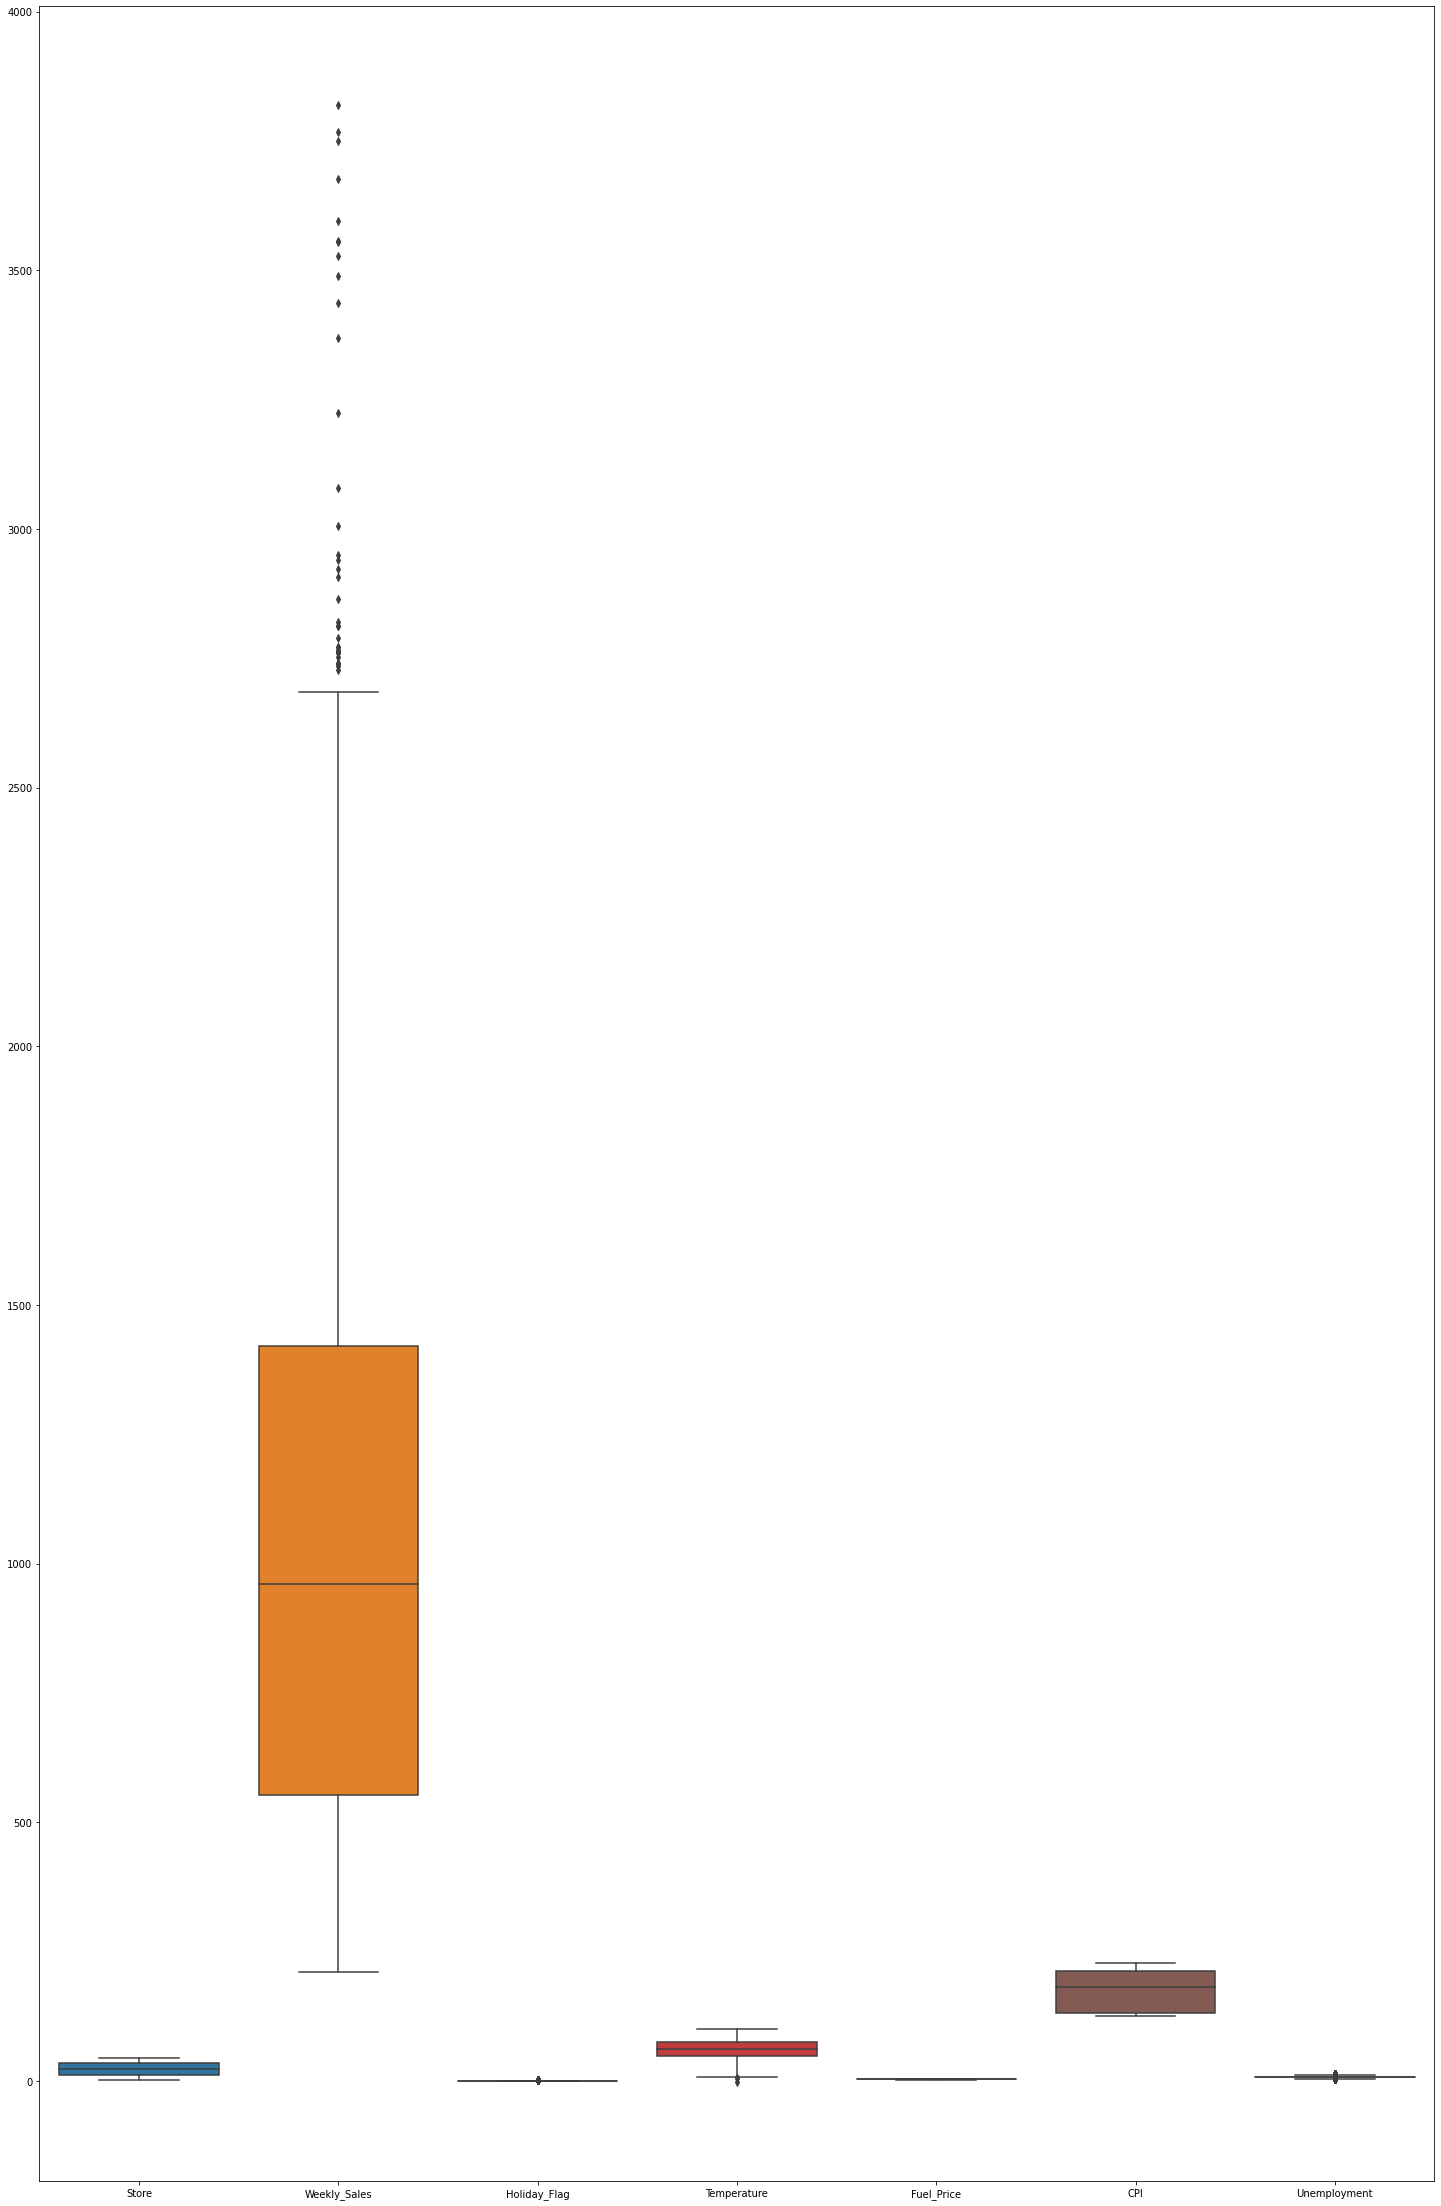

In [9]:
plt.figure(figsize=(25,40))
sns.boxplot(data= df[quan_field] ) 
plt.show()

El siguiente grafico se realizo con la finalidad de aprecia que sucedia con los valores "Unemployment" (desempleo) segun el numero de tiendas y podemos ver que no existen valores atipicos.

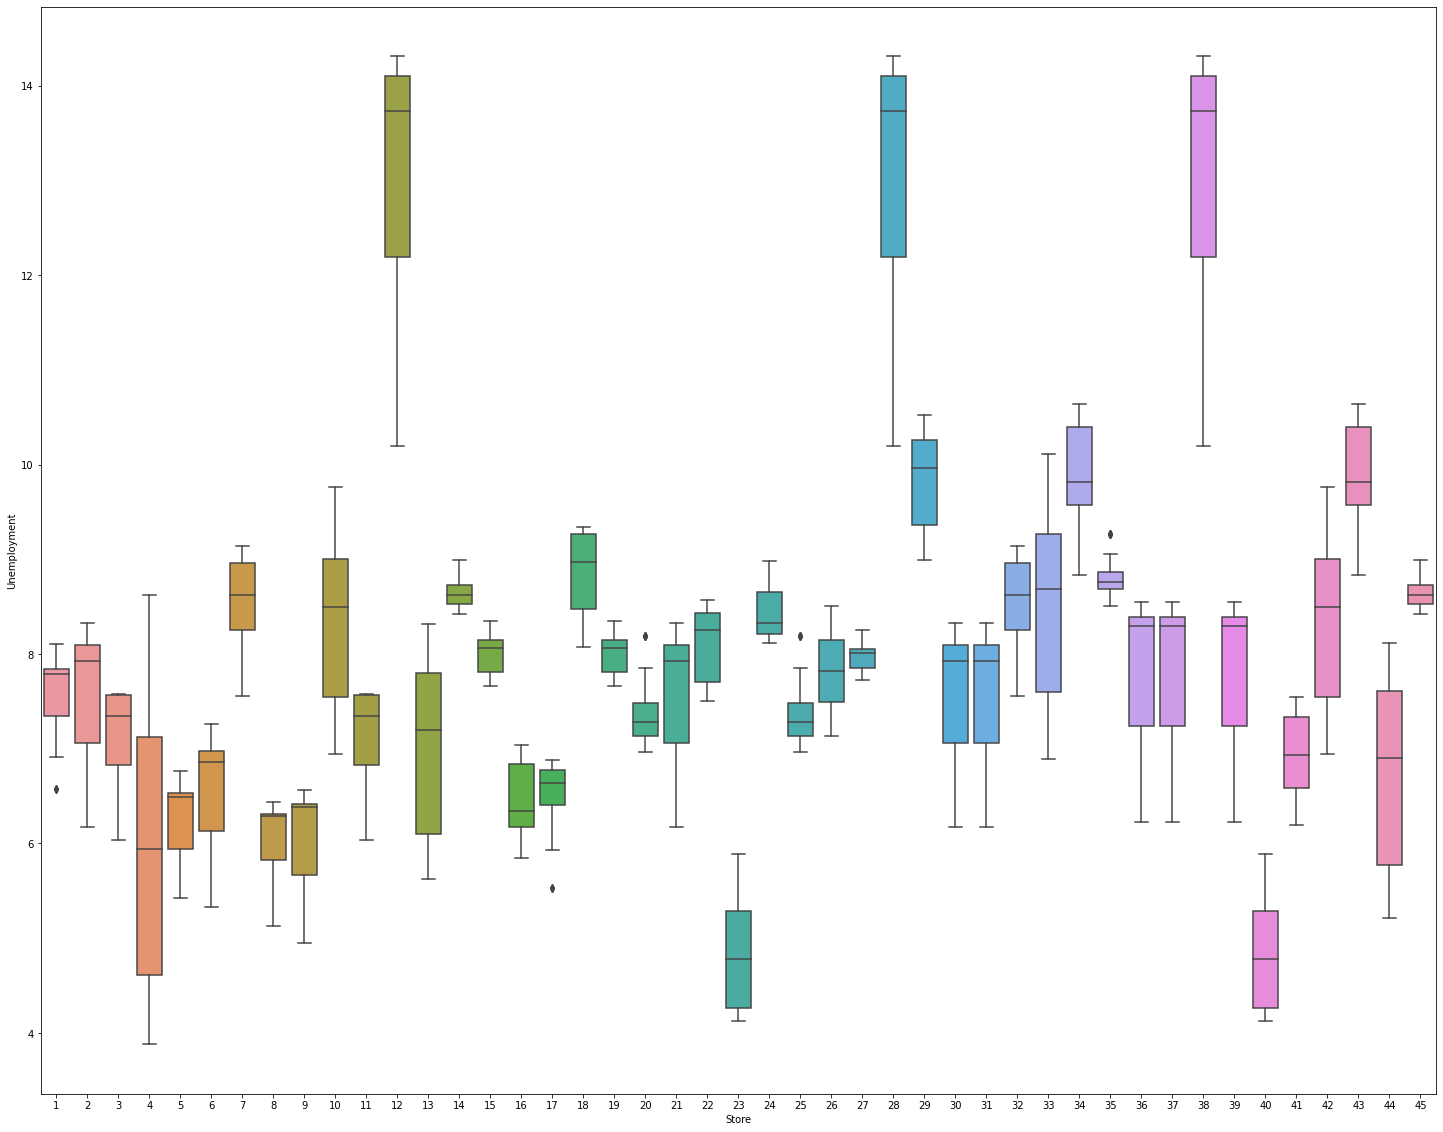

In [10]:
fields_to_analice = ['Store',
 'Unemployment', 'Temperature','Weekly_Sales']
import seaborn as sns
import matplotlib.pyplot as plt
edf= df[fields_to_analice]
gf=  edf.groupby('Store')
gf.first()
plt.figure(figsize=(25,20))
sns.boxplot(x="Store", y="Unemployment",  data=edf)
plt.show()

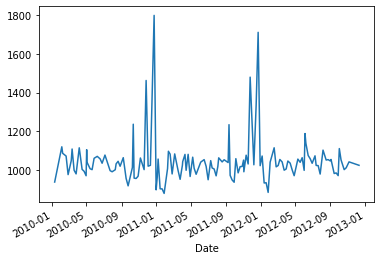

In [11]:
df.groupby("Date")["Weekly_Sales"].mean().plot()

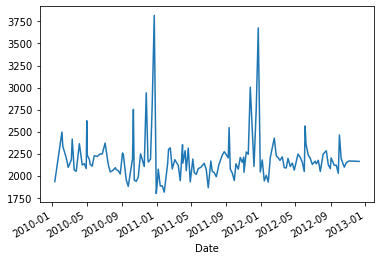

In [12]:
df.groupby("Date")["Weekly_Sales"].max().plot()

Realizando un agrupamiento por fecha podemos apreciar que los valores que marcan como ouliers corresponden a fechas especianes como navidad y black friday donde las personas realizan mas compras.

# 5. Grafique las distribuciones de las variables y a priori comente sobre ellas. 

En este apartado podemos apreciar que la unica varible que se asemeja a un distribucion normal es la temperatura.

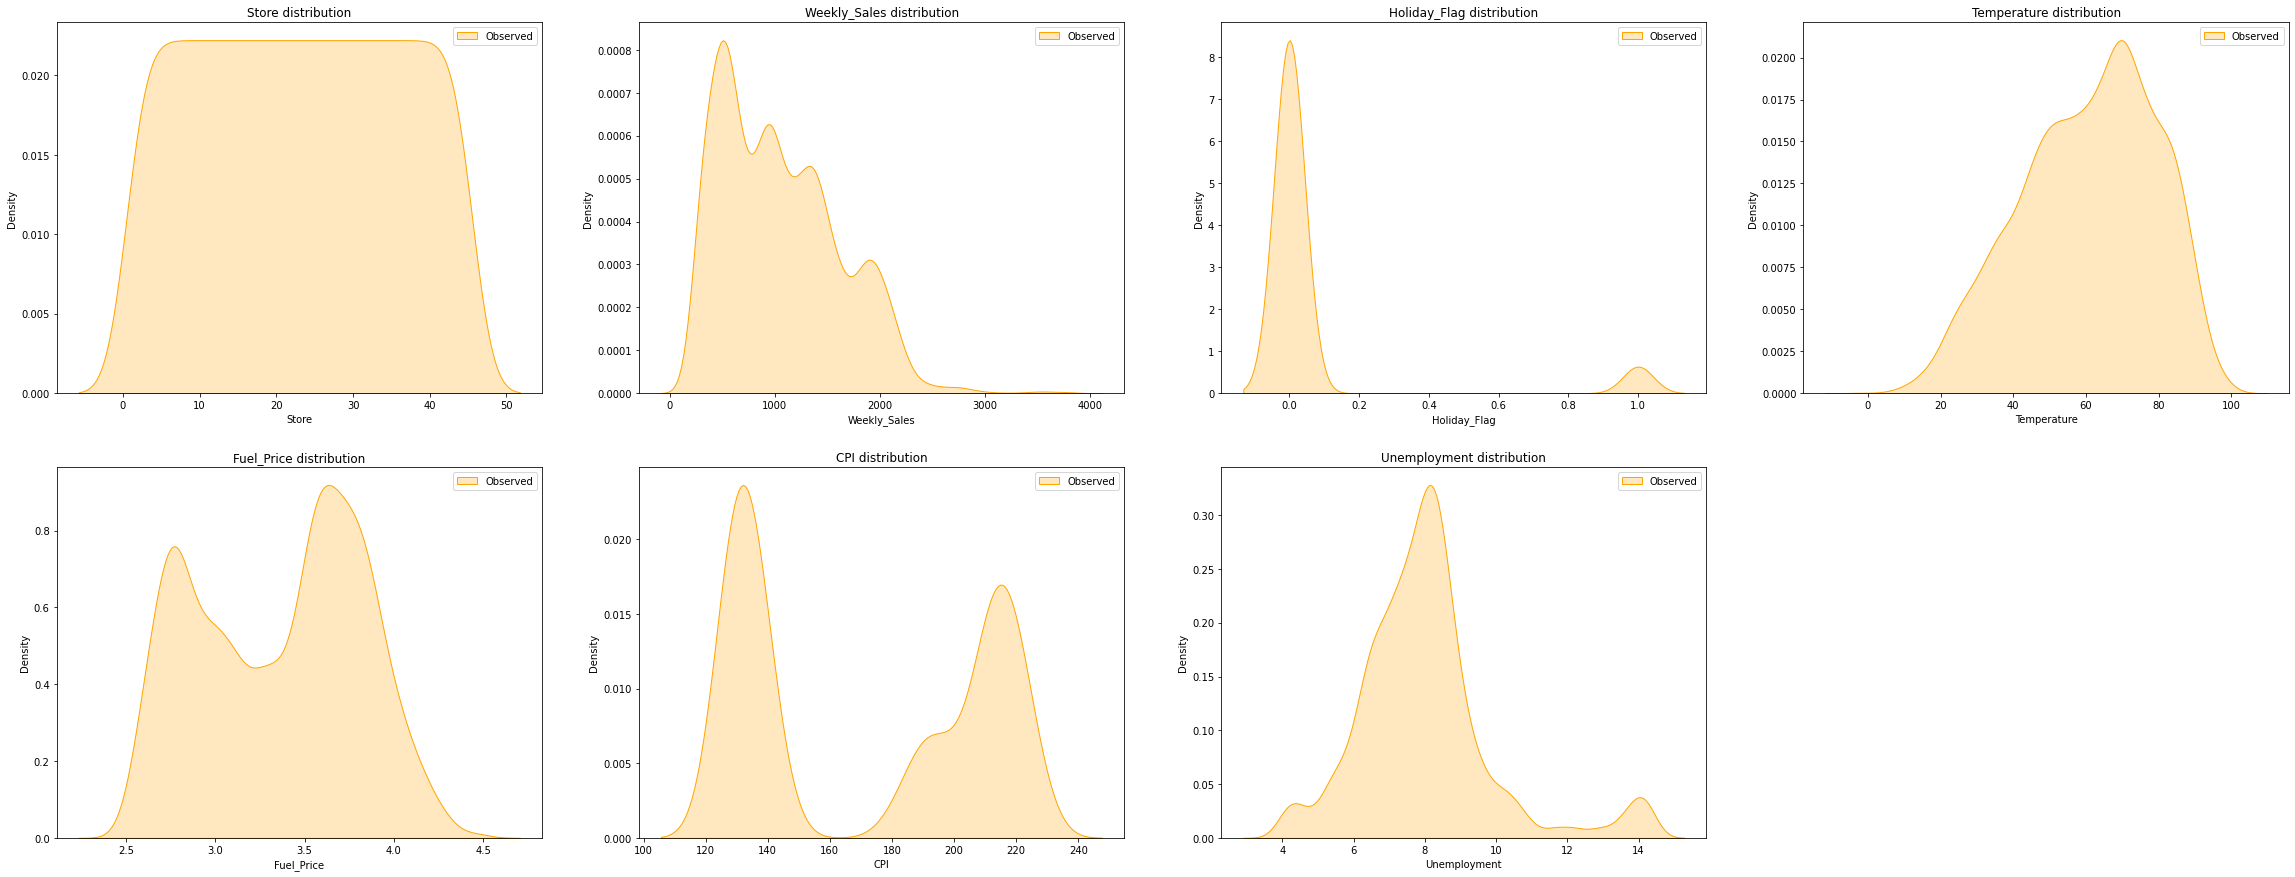

In [13]:
def pot(j, colkm):
    i  = int((4+j)/4) if j<5 else int((j)/4) 
    
    j= j+1
    plt.subplot(2,4,j)
    plt.title(str(colkm)+" distribution")
    sns.kdeplot(list(df[colkm]), shade="true", label="Observed", color = 'orange')
    plt.legend()
    plt.xlabel(colkm)


plt.figure(figsize=(40,15))
pot(0, quan_field[0])
pot(1, quan_field[1])
pot(2, quan_field[2])
pot(3, quan_field[3])
pot(4, quan_field[4])
pot(5, quan_field[5])
pot(6, quan_field[6])

plt.show()

# 6. Obtenga las correlaciones entre los datos de corte numérico. 

Claramente no existe una correlacion en las variables de core numerico ya que ningun valor es cercano a 1


In [14]:
print(df.columns)
df.corr().style.background_gradient(cmap='coolwarm')

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000,-0.335332,-0.000000,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-0.335332,1.000000,0.036891,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-0.000000,0.036891,1.000000,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-0.022659,-0.063810,-0.155091,1.000000,0.144982,0.176888,0.101158
Fuel_Price,0.060023,0.009464,-0.078347,0.144982,1.000000,-0.170642,-0.034684
CPI,-0.209492,-0.072634,-0.002162,0.176888,-0.170642,1.000000,-0.302020
Unemployment,0.223531,-0.106176,0.010960,0.101158,-0.034684,-0.302020,1.000000


In [15]:
quan_field

['Store',
 'Weekly_Sales',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment']

# 7. Comente que variable escogerán como variable dependiente y que variables introducirán a su modelo.

Como el analisis que estaremos llevando a cabo es el de tipo panel mi variable indepediente sera ventas por semana "Weekly_Sales"

In [16]:
import statsmodels.api as sm

In [17]:
df=df2.set_index(['Date','Store'])
 
dates = df.index.get_level_values('Date').to_list()
df['Date'] = pd.Categorical(dates)


x = sm.tools.tools.add_constant(df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
y = df['Weekly_Sales']
df

,,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date
Date,Store,,,,,,,
05-02-2010,1,1643.691,0,42.31,2.572,211.096358,8.106,05-02-2010
12-02-2010,1,1641.957,1,38.51,2.548,211.242170,8.106,12-02-2010
19-02-2010,1,1611.968,0,39.93,2.514,211.289143,8.106,19-02-2010
26-02-2010,1,1409.728,0,46.63,2.561,211.319643,8.106,26-02-2010
05-03-2010,1,1554.807,0,46.50,2.625,211.350143,8.106,05-03-2010
...,...,...,...,...,...,...,...,...
28-09-2012,45,713.174,0,64.88,3.997,192.013558,8.684,28-09-2012
05-10-2012,45,733.455,0,64.89,3.985,192.170412,8.667,05-10-2012
12-10-2012,45,734.464,0,54.47,4.000,192.327265,8.667,12-10-2012


# 8. Indique que tipo de modelación realizarán y porqué. 


Como el tipo de analisis que vamos a usar es de tipo panel escojere como variable dependiente  a ventas por semana "Weekly_Sales" . He decidido utilizar este modelo ya que:
1) Tenemos series de tiempo.
2) Tenemos grupos que claramente son los stores
Esto me permiete ver que temos datos en forma de panel.

In [18]:
modelo1 = PooledOLS(y, x)
resultados_pooled_OLS = modelo1.fit(cov_type='clustered', cluster_entity=True)

In [19]:
# Store values for checking homoskedasticity graphically
predicciones_pooled_OLS = resultados_pooled_OLS.predict().fitted_values
residuos_pooled_OLS = resultados_pooled_OLS.resids
residuos_pooled_OLS

Date        Store
05-02-2010  1        637.908105
12-02-2010  1        632.745828
19-02-2010  1        603.672523
26-02-2010  1        407.990555
05-03-2010  1        553.786685
                        ...    
28-09-2012  45      -261.604897
05-10-2012  45      -241.913935
12-10-2012  45      -249.701147
19-10-2012  45      -264.641817
26-10-2012  45      -221.479353
Name: residual, Length: 6435, dtype: float64

# 9. Verifique los supuestos, de haber escogido el enfoque econométrico.

Debemos verificar Homocedasticidad y No- autocorrelación.



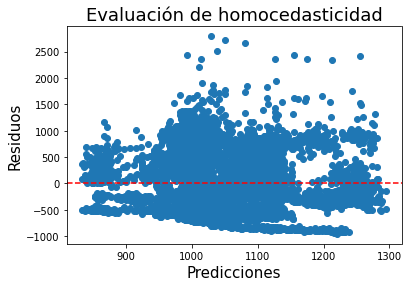

In [20]:
fig, ax = plt.subplots()
ax.scatter(predicciones_pooled_OLS, residuos_pooled_OLS)
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicciones', fontsize = 15)
ax.set_ylabel('Residuos', fontsize = 15)
ax.set_title('Evaluación de homocedasticidad', fontsize = 18)
plt.show()

In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan
pooled_OLS_df = pd.concat([df, residuos_pooled_OLS], axis=1)
pooled_OLS_df = pooled_OLS_df.drop(['Date'], axis = 1).fillna(0)
X_ = sm.tools.tools.add_constant(df['Unemployment'	]).fillna(0)

X_


,,const,Unemployment
Date,Store,,
05-02-2010,1,1.0,8.106
12-02-2010,1,1.0,8.106
19-02-2010,1,1.0,8.106
26-02-2010,1,1.0,8.106
05-03-2010,1,1.0,8.106
...,...,...,...
28-09-2012,45,1.0,8.684
05-10-2012,45,1.0,8.667
12-10-2012,45,1.0,8.667


In [22]:
pooled_OLS_df.residual


Date        Store
05-02-2010  1        637.908105
12-02-2010  1        632.745828
19-02-2010  1        603.672523
26-02-2010  1        407.990555
05-03-2010  1        553.786685
                        ...    
28-09-2012  45      -261.604897
05-10-2012  45      -241.913935
12-10-2012  45      -249.701147
19-10-2012  45      -264.641817
26-10-2012  45      -221.479353
Name: residual, Length: 6435, dtype: float64

In [23]:
breusch_pagan = het_breuschpagan(pooled_OLS_df.residual, X_)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan)))

{'LM-Stat': 66.89091182903013, 'LM p-val': 2.8695475322569316e-16, 'F-Stat': 67.572528962399, 'F p-val': 2.434692579402237e-16}


Como el p-valor del estadístico de Breush-Pagan es < 0.05 (2.869586731938867e-16), entonces se rechaza la hipótesis nula, y por lo tanto estamos en la presencia de heterocedasticidad en el término del error.

- Ho:Las varianzas del error son iguales, hay presencia de homocedasticidad
- Hi:Las varianzas del error no son iguales, hay presencia de heterocedasticidad

In [24]:
from statsmodels.stats.stattools import durbin_watson


In [25]:
durbin_watson = durbin_watson(pooled_OLS_df.residual) 
print(durbin_watson)

0.1125704797444718


En nuestro ejercicio, el resultado es 0.112, lo que indica claramente una fuerte autocorrelación positiva, violándose el supuesto.

Como las dos secciones del tercer supuesto fueron contradichas, a seguir exploraremos los modelos de efectos fijos y efectos aleatorios:

# 10. Obtenga el modelo definitivo, prediga los valores y comente el grado de ajuste del modelo. Justifique con métricas su respuesta.

Como los supuestos en el ejercicio anterion fracasaron en esta seccion hemos explorado los modelos de efectos fijos y efectos aleatorios. Como resultado del estudio mediante la prueba de hausman concluimos que la mejor opcion es el modelo de ramdom efects.

In [26]:
from linearmodels import PanelOLS

In [27]:
modelo_fe = PanelOLS(y, x, entity_effects = True)
resultados_fe = modelo_fe.fit()
resultados_fe

Dep. Variable:,Weekly_Sales,R-squared:,0.0291
Estimator:,PanelOLS,R-squared (Between):,-1.3479
No. Observations:,6435,R-squared (Within):,0.0291
Date:,"Wed, Dec 28 2022",R-squared (Overall):,-0.0338
Time:,04:21:09,Log-likelihood,-4.966e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,47.068
Entities:,143,P-value,0.0000
Avg Obs:,45.000,Distribution:,"F(4,6288)"
Min Obs:,45.000,,
Max Obs:,45.000,F-statistic (robust):,47.068


In [28]:
from linearmodels import RandomEffects

In [29]:
modelo_re = RandomEffects(y, x)
resultados_re = modelo_re.fit()
predicho_random = resultados_re.predict().fitted_values
resultados_re

Dep. Variable:,Weekly_Sales,R-squared:,0.0247
Estimator:,RandomEffects,R-squared (Between):,-0.0029
No. Observations:,6435,R-squared (Within):,0.0253
Date:,"Wed, Dec 28 2022",R-squared (Overall):,0.0240
Time:,04:21:09,Log-likelihood,-4.974e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,40.646
Entities:,143,P-value,0.0000
Avg Obs:,45.000,Distribution:,"F(4,6430)"
Min Obs:,45.000,,
Max Obs:,45.000,F-statistic (robust):,40.646


In [30]:
import numpy.linalg as la
from scipy import stats
import numpy as np

In [31]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval
hausman = hausman(resultados_fe, resultados_re) 

In [32]:
print('chi-Squared: ' + str(hausman[0]))
print('degrees of freedom: ' + str(hausman[1]))
print('p-Value:' + str(hausman[2]))

chi-Squared: 28.84764007584906
degrees of freedom: 5
p-Value:2.4839163160733927e-05


Como el valor p es muy pequeño (0.5), la hipótesis nula no puede rechazarse. En consecuencia, el modelo de random effects parece ser el más adecuado.

# 11. Grafique a los valores predicho de modelo vs los valores reales.
¿Cómo se ven una vez graficados frente a los valores reales? Argumente su respuesta. 

Los valores predichos vs los reales no se parecen ademas las graficas de error muestran valores realmente grandes el 

---



Date        Store
05-02-2010  1        594.371519
12-02-2010  1        624.899971
19-02-2010  1        599.916765
26-02-2010  1        482.886982
05-03-2010  1        559.618790
                        ...    
28-09-2012  45      -206.378254
05-10-2012  45      -257.343160
12-10-2012  45      -213.900363
19-10-2012  45      -203.947433
26-10-2012  45      -171.977366
Name: residual, Length: 6435, dtype: float64

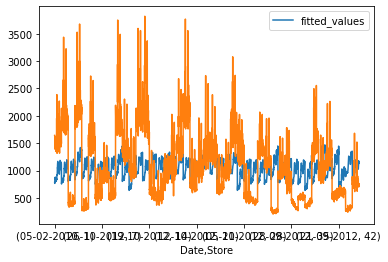

In [33]:
resultados_fe.predict().plot()
df['Weekly_Sales'].plot()
resultados_fe.resids


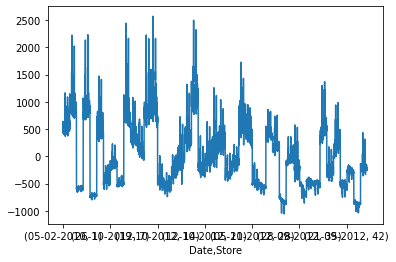

In [34]:
resultados_re.resids.plot()

#  12 .Concluya sobre su modelo. Para ello, si escogió el enfoque econométrico, interprete coeficientes, por el contrario si escogió el enfoque de machine learning, determine cuáles son las variables que tienen mayor poder explicativo sobre su variable objetivo. 

# 13. Suba su proyecto final en su cuenta de Github y adjunte una captura de pantalla en esta plataforma. 